# Variational AutoEncoder (VAE)

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
import matplotlib.pyplot as plt

## VAE model

In [82]:
IMG_SHAPE = (28, 28, 1)
LATENT_DIM = 128
KERNEL_SIZE = 4

# Encode the image into the latent space of dimension LATENT_DIM
def build_encoder():
    inputs = Input(shape=IMG_SHAPE)
    x = layers.Conv2D(32, KERNEL_SIZE, strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, KERNEL_SIZE, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, KERNEL_SIZE, strides=2, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    z_mean = layers.Dense(LATENT_DIM)(x)
    z_log_var = layers.Dense(LATENT_DIM)(x)
    return Model(inputs, [z_mean, z_log_var], name='encoder')

In [83]:
# Sample from latent space the vector z = mean + sqrt(exp(log_var)) * epsilon
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [84]:
# Decode from the latent space the original image
def build_decoder(conditional=False):
  latent_inputs = Input(shape=(LATENT_DIM,))
  x = layers.Dense(7 * 7 * LATENT_DIM, activation='relu')(latent_inputs)
  x = layers.Reshape((7, 7, LATENT_DIM))(x)
  x = layers.Conv2DTranspose(64, KERNEL_SIZE, strides=2, padding='same', activation='relu')(x)
  x = layers.Conv2DTranspose(32, KERNEL_SIZE, strides=2, padding='same', activation='relu')(x)
  outputs = layers.Conv2D(1, KERNEL_SIZE-1, padding='same', activation='sigmoid')(x)
  return Model(latent_inputs, outputs, name='decoder')

In [93]:
# VAE class that has an encoder, a sampler, a decoder and the VAE loss
class VAE(Model):

  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.sampler = Sampling()
    self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")

  def compile(self, optimizer):
    super().compile()
    self.optimizer = optimizer
    self.recon_loss_fn = tf.keras.losses.MeanSquaredError()

  def train_step(self, data):

    if isinstance(data, tuple):
      data = data[0]

    with tf.GradientTape() as tape:
      z_mean, z_log_var = self.encoder(data)
      z = self.sampler([z_mean, z_log_var])
      decoded_image = self.decoder(z)
      loss = self.vae_loss(data, decoded_image, (z_mean, z_log_var))

    grads = tape.gradient(loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(loss)
    return {
      "loss": self.total_loss_tracker.result()
    }

  def vae_loss(self, data, decoded_image, encoder_output):
    gamma = 0.0001
    z_mean, z_log_var = encoder_output
    recon_loss = (self.recon_loss_fn(data, decoded_image))
    kl_loss = -0.5 * tf.keras.backend.sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return recon_loss + gamma * kl_loss

## Data preparation

In [44]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


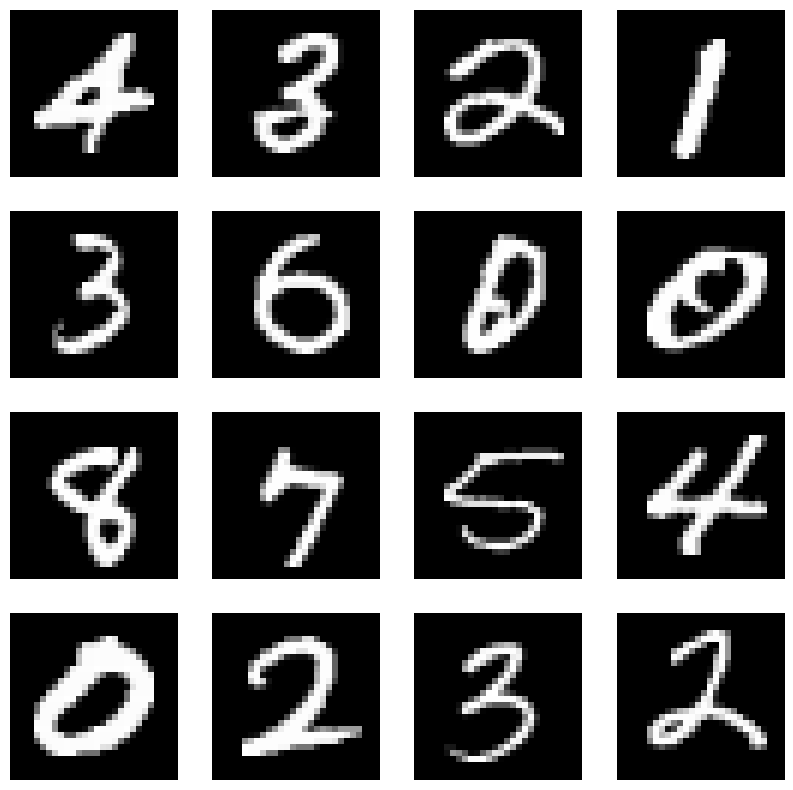

In [48]:
indices = np.random.choice(len(x_train), 16, replace=False)
images = x_train[indices]

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.axis("off")
plt.show()

## Training

In [94]:
encoder = build_encoder()
decoder = build_decoder()
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-3))

vae.fit(
    x_train,
    batch_size=64,
    epochs=30
)

Epoch 1/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0518
Epoch 2/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0148
Epoch 3/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0125
Epoch 4/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0117
Epoch 5/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0113
Epoch 6/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0110
Epoch 7/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0108
Epoch 8/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0107
Epoch 9/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0105
Epoch 10/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0104
Epoch 11/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0103
Epoch 12/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0102
Epoch 13/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0101
Epoch 14/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0101
Epoch 15/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/s

## Testing

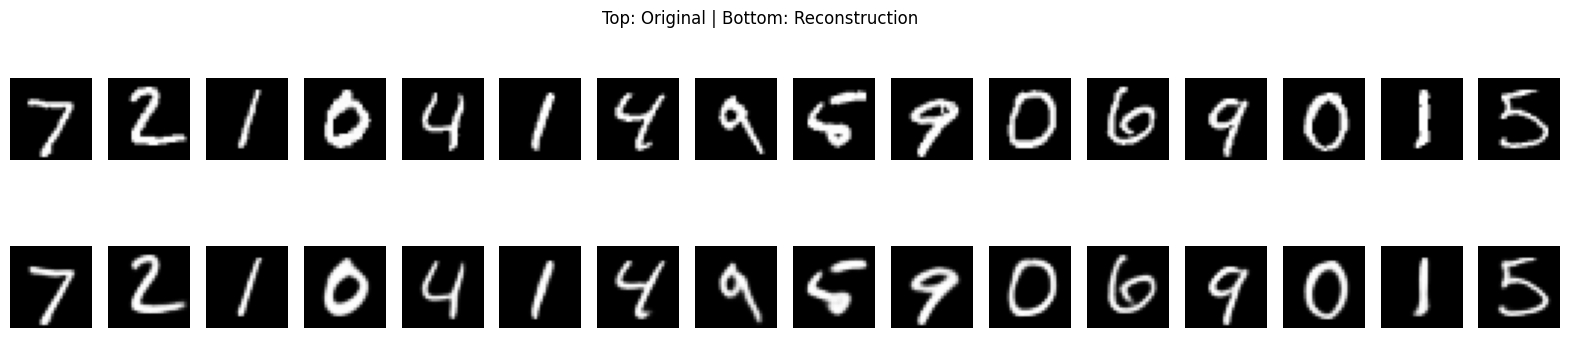

In [95]:
# Show real images reconstruction

real_images = x_test[:16]

z_mean, z_log_var = vae.encoder(real_images)
z = vae.sampler([z_mean, z_log_var])
recon_images = vae.decoder(z)

# Plot
n = len(real_images)
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(real_images[i], cmap="gray")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_images[i], cmap="gray")
    plt.axis("off")

plt.suptitle("Top: Original | Bottom: Reconstruction")
plt.show()

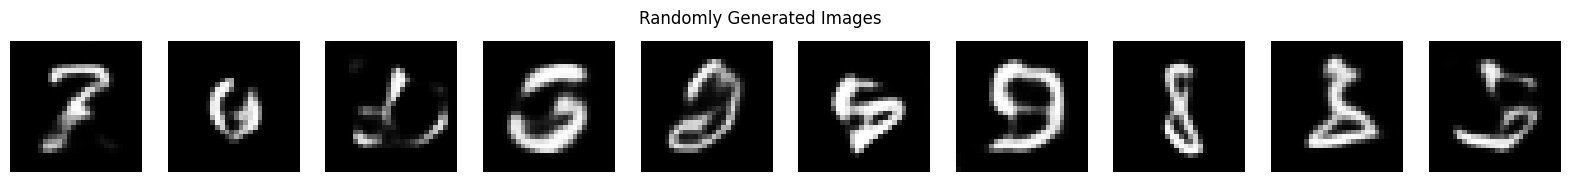

In [96]:
def sample_and_plot(decoder, n=10):
    z_random = tf.random.normal(shape=(n, LATENT_DIM))
    generated = decoder(z_random)

    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(generated[i], cmap="gray")
        plt.axis("off")
    plt.suptitle("Randomly Generated Images")
    plt.show()

sample_and_plot(vae.decoder)

# Conditional VAE